In [1]:
from typing import Tuple

import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from tqdm import tqdm
from solver import Up2P
from utils.rotation_utils import get_upward_with_dev, get_rt_mtx, validate_sol

%matplotlib inline

In [2]:
from dataclasses import dataclass

@dataclass
class Config:
    max_depth: float = 10.
    img_width: int = 640
    img_height: int = 640
    focal_length: int = 3 * (img_width * 0.5) / np.tan(60.0 * np.pi / 180.0);
    min_depth: float = 1.
    max_depth: float = 1.1
    inliers_ratio: float = 1.
    outlier_dist: float = 30.
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    pixel_noise: float = 0.
    
conf = Config()
dtype = torch.float64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def generate_correspondence(x: torch.tensor, conf: Config):
    x = to_camera_coords(x, conf)
    x *= random.uniform(conf.min_depth, conf.max_depth)
    
    assert x.shape == (3,)    
    return x

def transform_correspondence(X: torch.tensor, R: torch.tensor, t: torch.tensor):
    return R @ X + t

def to_homogeneous(x):
    return torch.cat([x, torch.ones(1)])

def to_camera_coords(x: torch.tensor, conf: Config = conf):
    x = to_homogeneous(x)
    
    x[0] -= conf.img_width // 2
    x[1] -= conf.img_height // 2
    x[:2] /= conf.focal_length
    x /= x.norm()
    
    return x

def reproject(X, R, t, conf: Config = conf):
    translated = R.T @ (X - t)
    translated[:2] /= translated[2]
    translated[:2] *= conf.focal_length
    translated[0] += conf.img_width // 2
    translated[1] += conf.img_height // 2
    
    return translated[:2]

In [4]:
from utils.rotation_utils import get_random_upward

def get_random_image_point(conf: Config):
    x = random.uniform(0, conf.img_width)
    y = random.uniform(0, conf.img_height)
    x = torch.tensor([x, y], dtype=torch.float64)    
    return x


def generate_example(R, t, conf: Config = conf):
    x1, x2 = get_random_image_point(conf), get_random_image_point(conf)
    X1, X2 = generate_correspondence(x1.clone(), conf),\
             generate_correspondence(x2.clone(), conf)
    X1, X2 = transform_correspondence(X1, R, t), transform_correspondence(X2, R, t)
    
    # [TODO][IMPORTNAT]: not properly tested, be aware of using for
    # some experiments
    if conf.pixel_noise != 0:
        x1noise = np.random.normal(0, conf.pixel_noise, 2)
        x2noise = np.random.normal(0, conf.pixel_noise, 2)
        
        if torch.all(x1[0] + x1noise > 0) and torch.all(x1[1] + x1noise < conf.img_width):
            x1 += x1noise
            assert x1[0] > 0 and x1[1] < conf.img_width, f"{x1}"
            
        if torch.all(x2[0] + x2noise > 0) and torch.all(x2[1] + x2noise < conf.img_height):
            x2 += x2noise
            assert x2[0] > 0 and x2[1] < conf.img_height, f"{x2}"
        
        assert x1[0] > 0 and x1[1] < conf.img_width, f"{x1}"
        assert x2[0] > 0 and x2[1] < conf.img_height, f"{x2}"
        
    return x1, x2, X1, X2 
        
def generate_examples(num_of_examples: int,
                      dev: Tuple[float, float] = (0., 0.), conf: Config = conf):
    num_of_examples = num_of_examples // 2
    
    num_inliers = num_of_examples * conf.inliers_ratio
    num_outliers = num_of_examples - num_inliers
    
    if num_of_examples == 0:
        num_of_examples, num_inliers, num_outliers = 1, 1, 0
    
    R, rand_angle = get_random_upward(*dev)
    t = torch.rand(3, )
        
    # [TODO] [IMPORTANT]: under such generation we cannot get model where one of the points is an inlier
    xs, Xs, inliers = [], [], []
    for i in range(num_of_examples):
        x1, x2, X1, X2 = generate_example(R, t)
        Xs.append((X1, X2))
        
        if i < num_inliers:
            xs.append((x1, x2))
            inliers.append(True)
        else:
            xs.append((generate_outlier(x1, conf), generate_outlier(x2, conf)))
            inliers.append(False)
            
    return xs, Xs, inliers, R, t, rand_angle

100%|██████████| 1000/1000 [00:02<00:00, 436.27it/s]


res=679, skipped=319, Success rate: 0.9970631424375918


(array([118.,  67.,  43.,  43.,  37.,  46.,  50.,  66.,  77., 134.]),
 array([1.81807863, 1.91911347, 2.02014832, 2.12118317, 2.22221801,
        2.32325286, 2.4242877 , 2.52532255, 2.6263574 , 2.72739224,
        2.82842709]),
 <BarContainer object of 10 artists>)

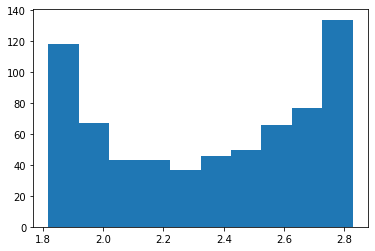

In [ ]:
PREROTATE = True
res = 0
skipped = 0

rot_errors = []
for _ in tqdm(range(1000)):
    solver = Up2P()

    x=0
    z=40
    prerot = get_rt_mtx(roll=x, pitch=0, yaw=z, device=device, dtype=torch.float64)

    xs, Xs, _, Rg, tg, rand_angle = generate_examples(2, dev=(x, z))
    xs, Xs = list(xs[0]), list(Xs[0])
    txs, tXs = xs[1][0], Xs[1][0]

    xsc = torch.zeros((2, 3))
    xsc[0] = to_camera_coords(xs[0], conf)
    xsc[1] = to_camera_coords(xs[1], conf)

    if PREROTATE:
        Xs = [prerot @ X for X in Xs]

    err, Re, te = None, None, None
    for R, t in solver(xsc, torch.stack(Xs)):   
        # t = -R.T @ t # done by the solve itself
        rp = R.T @ (tXs - t)
        rp[:2] /= rp[2]
        rp[:2] *= conf.focal_length
        rp[0] += conf.img_width // 2
        rp[1] += conf.img_height // 2
        rp = rp[:2]
    
        # rp = reproject(tXs, R, t, conf)
        cerr = (txs - rp).norm()
        if err is None or cerr < err:
            err = cerr
            Re, te = R, t

    if Re is None:
        # print(cerr)
        skipped += 1
    else:
        res += torch.allclose(reproject(Xs[0], Re, te, conf), xs[0]) and torch.allclose(reproject(Xs[1], Re, te, conf), xs[1])
        true_R = prerot.T @ Re
        rot_errors.append((Rg - true_R).norm())
        
print(f"{res=}, {skipped=}, Success rate: {res / (1000 - skipped)}")
plt.hist(rot_errors)

100%|██████████| 1000/1000 [00:02<00:00, 342.52it/s]


res=993, skipped=0, Success rate: 0.993


(array([360., 186.,  62.,  53.,  49.,  64.,  51.,  61.,  53.,  61.]),
 array([0.96737901, 1.04312839, 1.11887777, 1.19462715, 1.27037653,
        1.34612591, 1.42187529, 1.49762467, 1.57337405, 1.64912343,
        1.72487281]),
 <BarContainer object of 10 artists>)

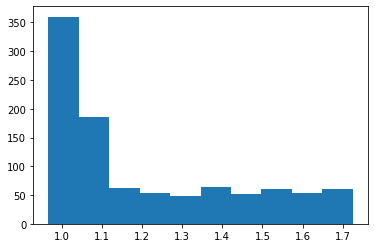

In [6]:
res = 0
skipped = 0
rot_errors = []

for _ in tqdm(range(1000)):

    solver = Up2P()

    xs, Xs, _, Rg, tg, rand_angle = generate_examples(2, dev=(0, 0))
    xs, Xs = list(xs[0]), list(Xs[0])
    txs, tXs = xs[1][0], Xs[1][0]

    xsc = torch.zeros((2, 3))
    xsc[0] = to_camera_coords(xs[0], conf)
    xsc[1] = to_camera_coords(xs[1], conf)

    err, Re, te = None, None, None
    for R, t in solver(xsc, torch.stack(Xs)):    
        rp = reproject(tXs, R, t, conf)
        cerr = (txs - rp).norm()
        
        if err is None or cerr < err:
            err = cerr
            Re, te = R, t

    if Re is None:
        skipped += 1
    else:
        res += torch.allclose(reproject(Xs[0], Re, te, conf), xs[0]) and torch.allclose(reproject(Xs[1], Re, te, conf), xs[1])
        rot_errors.append((Rg - true_R).norm())
    
print(f"{res=}, {skipped=}, Success rate: {res / (1000 - skipped)}")
plt.hist(rot_errors)